* # Import Libraries

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
print(os.listdir("../input"))

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

['.DS_Store', 'test.csv', 'submission.csv', 'ks-projects-201801.csv', 'train.csv', 'sample_submission.csv']


# 1. Data Loading

In [171]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [172]:
print("train.shape", train.shape, "test shape", test.shape)

train.shape (1458644, 11) test shape (625134, 9)


In [173]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [174]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# 2. Analysis

In [176]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [177]:
train.trip_duration.min()

1

In [178]:
train.trip_duration.max()

3526282

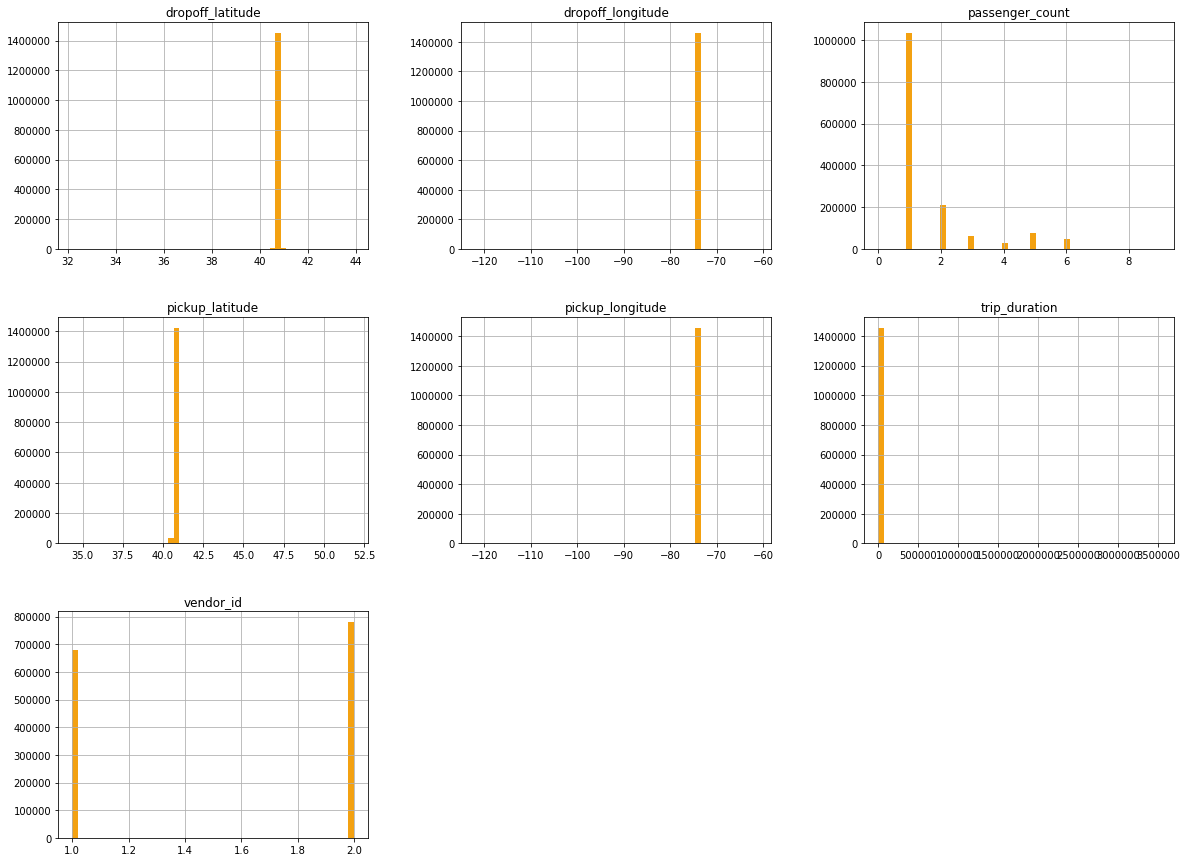

In [179]:
train.hist(bins=50, figsize=(20,15), color="#F3A111")
plt.show()

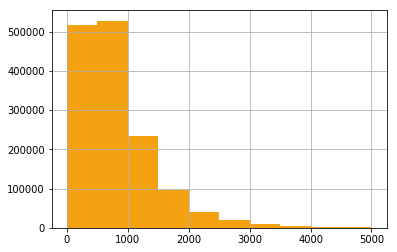

In [180]:
train.loc[train['trip_duration'] < 5000, 'trip_duration'].hist(color="#F3A111");

# 3. Data preprocessing :

#### Data Cleaning

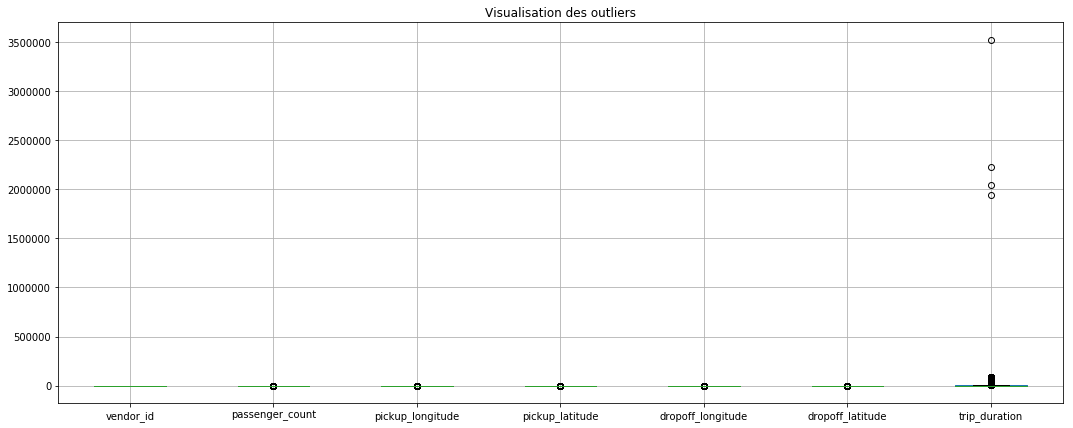

In [181]:
plt.subplots(figsize=(18,7))
plt.title("Visualisation des outliers")
train.boxplot();

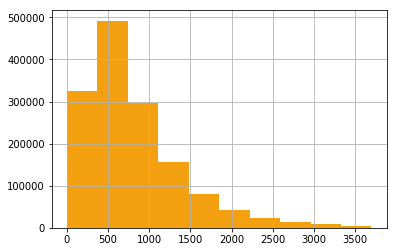

In [182]:
train.loc[train['trip_duration'] < 3700, 'trip_duration'].hist(color="#F3A111");

In [183]:
train = train[train['trip_duration']<= 3700]

In [184]:
train = train[(train['trip_duration'] > 60) & (train['trip_duration'] < 3600 * 24)]

train['hour'] = train['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

train['distance'] = np.sqrt((train['pickup_latitude']-train['dropoff_latitude'])**2
                        + (train['pickup_longitude']-train['dropoff_longitude'])**2)


test['hour'] = test['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

test['distance'] = np.sqrt((test['pickup_latitude']-test['dropoff_latitude'])**2
                        + (test['pickup_longitude']-test['dropoff_longitude'])**2)

train.shape, test.shape

((1438744, 13), (625134, 11))

In [185]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
hour                  0
distance              0
dtype: int64

# 4. Features selection

In [186]:
difference_col = list(set(train.columns).difference(set(test.columns)))

In [187]:
y_train = train["trip_duration"] # My target
X_train = train[["pickup_longitude","passenger_count", "pickup_latitude", "dropoff_longitude","dropoff_latitude","distance","hour"]] # features

X_datatest = test[["pickup_longitude","passenger_count", "pickup_latitude", "dropoff_longitude","dropoff_latitude","distance","hour"]]

In [188]:
train.drop(['hour','distance']+difference_col, axis=1, inplace=True)

# 5. Choix du modèle

In [189]:
#grd = SGDRegressor()

grd = SGDRegressor()
grd.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# 6. Cross-Validation

In [190]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

In [191]:
rff = RandomForestRegressor(n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
rff.fit(X_train, y_train)
rff.score(X_valid, y_valid)

0.7634169485725275

In [192]:
# calculate the cross validation scores of the model

cv = ShuffleSplit(n_splits=4, test_size=0.8, random_state=42)
cv_scores = cross_val_score(rff, X_train, y_train, cv=cv, scoring= 'neg_mean_squared_log_error')

In [193]:
cv_scores

array([-0.13693458, -0.13678208, -0.13744133, -0.13702739])

In [194]:
for i in range(len(cv_scores)):
    cv_scores[i] = np.sqrt(abs(cv_scores[i]))
print(np.mean(cv_scores))

0.3701975633776823


In [195]:
train_pred = rff.predict(X_datatest)

In [196]:
train_pred

array([ 805.92742082,  630.00901686,  438.72337253, ..., 1496.14535358,
       1999.09454887, 1097.66616921])

In [197]:
len(train_pred)

625134

In [198]:
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': train_pred})
my_submission.head()

,id,trip_duration
0,id3004672,805.927421
1,id3505355,630.009017
2,id1217141,438.723373
3,id2150126,1064.175691
4,id1598245,348.386658


In [199]:
my_submission.to_csv('submission.csv', index=False)